# Make Volumetric Graphs of Symmetry Evolutions

In [1]:
colors_base = {
"00":"c64_black",  
"01":"c64_white",  
"02":"c64_red",    
"03":"c64_cyan",   
"04":"c64_purple", 
"05":"c64_green",  
"06":"c64_blue",   
"07":"c64_yellow", 
"08":"c64_orange", 
"09":"c64_brown",  
"0a":"c64_ltred",  
"0b":"c64_gray1",  
"0c":"c64_lightgray",  
"0d":"c64_ltgreen",
"0e":"c64_ltblue", 
"0f":"c64_gray3",  
}
colors = [v for k,v in colors_base.items()]
    
c64_to_rgb = {
"c64_black": "#000000",     
"c64_white": "#ffffff",     
"c64_red": "#880000",       
"c64_cyan":  "#aaffee",     
"c64_purple": "#cc44cc",    
"c64_green": "#00cc55",     
#"c64_blue":  "#0000aa",     
"c64_blue":  "#0088ff",     
"c64_yellow":  "#eeee77",   
"c64_orange":  "#dd8855",   
"c64_brown": "#664400",     
"c64_ltred": "#ff7777",  
"c64_gray1":  "#333333",    
"c64_ltgreen": "#aaff66",
"c64_ltblue":  "#0088ff",
"c64_lightgrey": "#bbbbbb", 
"c64_lightgray": "#bbbbbb", 
"c64_gray3": "#bbbbbb",                             
}


Use this patch before building psychedelia.prg.

It changes demo mode to cycle through the available symmetries for each pattern.

```diff
diff --git a/bin/psychedelia.prg b/bin/psychedelia.prg
index 33f75db..389f6a9 100644
Binary files a/bin/psychedelia.prg and b/bin/psychedelia.prg differ
diff --git a/src/c64/psychedelia.asm b/src/c64/psychedelia.asm
index b83f7d1..c55ebbf 100644
--- a/src/c64/psychedelia.asm
+++ b/src/c64/psychedelia.asm
@@ -3226,6 +3226,7 @@ b1F2D   JSR PutRandomByteInAccumulator
         AND #$0F
         ORA joystickInputRandomizer
         EOR #$1F
+        LDA #$1F
         STA lastJoystickInput
         DEC demoModeCountDownToChangePreset
         BEQ b1F51
@@ -3234,13 +3235,29 @@ b1F2D   JSR PutRandomByteInAccumulator
 b1F51   JSR PutRandomByteInAccumulator
         AND #$07
 b1F56   ADC #$20
+        LDA #$10
         STA demoModeCountDownToChangePreset
         JSR PutRandomByteInAccumulator
         AND #$0F
         TAX 
         LDA #$00
         STA shiftPressed
-        JMP SelectNewPreset
+
+        LDA #$0F
+        STA lastJoystickInput
+        INC currentSymmetrySetting
+        LDA currentSymmetrySetting
+        CMP #$05
+        BNE RandomReturn
+        LDA #$00
+        STA currentSymmetrySetting
+        INC currentPatternElement
+        LDA currentPatternElement
+        AND #$0F
+        STA currentPatternElement
+
+RandomReturn
+        RTS
         ; Returns
 
 ;-------------------------------------------------------
@@ -3263,9 +3280,8 @@ b1F73   LDA demoMessage,X
 demoMessage
         .TEXT "      PSYCHEDELIA BY JEFF MINTER         "
 
-* = $1FA9
 demoModeCountDownToChangePreset
-        .BYTE $20
+        .BYTE $10
 NMIInterruptHandler
         .BYTE $A2,$F8,$9A,$A9,$0C,$48,$A9

```

Run the following command:
```sh
~/Dev/vice-emu-code/vice/src/x64sc -directory ~/Dev/vice-emu-code/vice/data/ -moncommands painttrace.txt bin/psychedelia.prg 
```
Where `painttrace.txt` is:

```
log on
logname "PsychedeliaSymmetryPaintTrace.txt"
tr exec 0973
command 1 "mem d800 dbff; mem 0e3e 0e52"
```



Read in the ram history.

In [2]:
log_file = "PsychedeliaSymmetryPaintTrace.txt"
input_file = open(log_file,'r')

ram_history = []
lines = input_file.readlines()
c = 0
for i in range(5, len(lines), 70):
    raw_ram = [l[9:60].split() for l in lines[i:i+64]]
    raw_ram = [int(v,16) & 0x0f for l in raw_ram for v in l]
    color_ram = list(reversed([raw_ram[v:v+40] for v in range(0, len(raw_ram), 40)]))[2:]
    
    raw_ram = [l[9:60].split() for l in lines[i+64:i+67]]
    raw_ram = [int(v,16) for l in raw_ram for v in l]
    settings_ram = raw_ram

    ram_history += [(color_ram,settings_ram)]
    c += 1


Slice up the ram history into the different patterns.

In [3]:
flatten = lambda l: [e for sublist in l for e in sublist]

pattern_breaks = []
ppindex = 0
psym = 0
for i,(h,s) in enumerate(ram_history):
    pindex = s[-7]
    sym = s[-1]
    if pindex == ppindex and sym == psym:
        continue
    psym, ppindex = sym, pindex
    pattern_breaks += [i]
pattern_breaks = pattern_breaks[1:]

patterns = []
pp = 0
for p in pattern_breaks:
    patterns += [ram_history[pp:p]]
    pp = p


Methods for culling the pixel data to just the volume that's occupied.

In [4]:
def firstNonZero(l):
    for i,e in enumerate(l):
        if e > 0:
            return i
    return i

def getLeftMostPixelForPattern(pattern):
    return min([firstNonZero(r) for scr in pattern for r in scr])

def getRightMostPixelForPattern(pattern):
    return len(pattern[0][0]) - min([firstNonZero(list(reversed(r)))
                     for scr in pattern for r in scr])

def rotatePatternToCols(pattern):
    pattern_cols = []
    for scr in pattern:
        col_arr = [[0 for i in range(len(scr))] for j in range(len(scr[0]))]
        for i,r in enumerate(scr):
            for j,v in enumerate(r):
                col_arr[j][i] = v
        pattern_cols += [col_arr]
    return pattern_cols

def cullPattern(pattern):
    first_left = getLeftMostPixelForPattern(pattern)
    last_right = getRightMostPixelForPattern(pattern)
    width = last_right - first_left

    pattern_as_cols = rotatePatternToCols(pattern)
    first_top = getLeftMostPixelForPattern(pattern_as_cols)
    last_bottom = getRightMostPixelForPattern(pattern_as_cols)
    height = last_bottom - first_top
    
    culled = [[r[first_left:last_right] 
              for r in scr[first_top:last_bottom]]
              for scr in pattern]
    return culled

#cullPattern(patterns[0])
#patterns[0]

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LightSource

In [24]:
import numpy as np
plt.rcParams["figure.figsize"] = (80,80)
plt.rcParams['figure.dpi'] = 30
import matplotlib.pyplot as plt

def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

def createVoxelData(screens):
    # prepare some coordinates
    width = len(screens[0][0])
    height = len(screens[0])
    x, y, z = np.indices((width,height,len(screens)))
    voxelarray = np.zeros((width,height,len(screens)), dtype=bool)
    colorarray = np.empty(voxelarray.shape, dtype=object)
    for zp,screen in enumerate(screens):
        for yp, row in enumerate(screen):
            for xp, col in enumerate(row):
                # Skip black, white and gray cells
                if col in [0,1,0x0c]:
                    continue
                cube = (x == xp) & (y == yp) & (z == zp)
                voxelarray |= cube
                color = c64_to_rgb[colors[col]]
                colorarray[cube] = color+"c0"

    # upscale the above voxel image, leaving gaps
    filled_2 = explode(voxelarray)
    ecolors_2 = explode(colorarray)

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.10
    y[:, 0::2, :] += 0.10
    z[:, :, 0::2] += 0.10
    x[1::2, :, :] += 0.90
    y[:, 1::2, :] += 0.90
    z[:, :, 1::2] += 0.90

    return ((x,y,z), filled_2, ecolors_2)

In [10]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img



 Finally, write out our visualisation of each pattern evolution.

KeyboardInterrupt: 

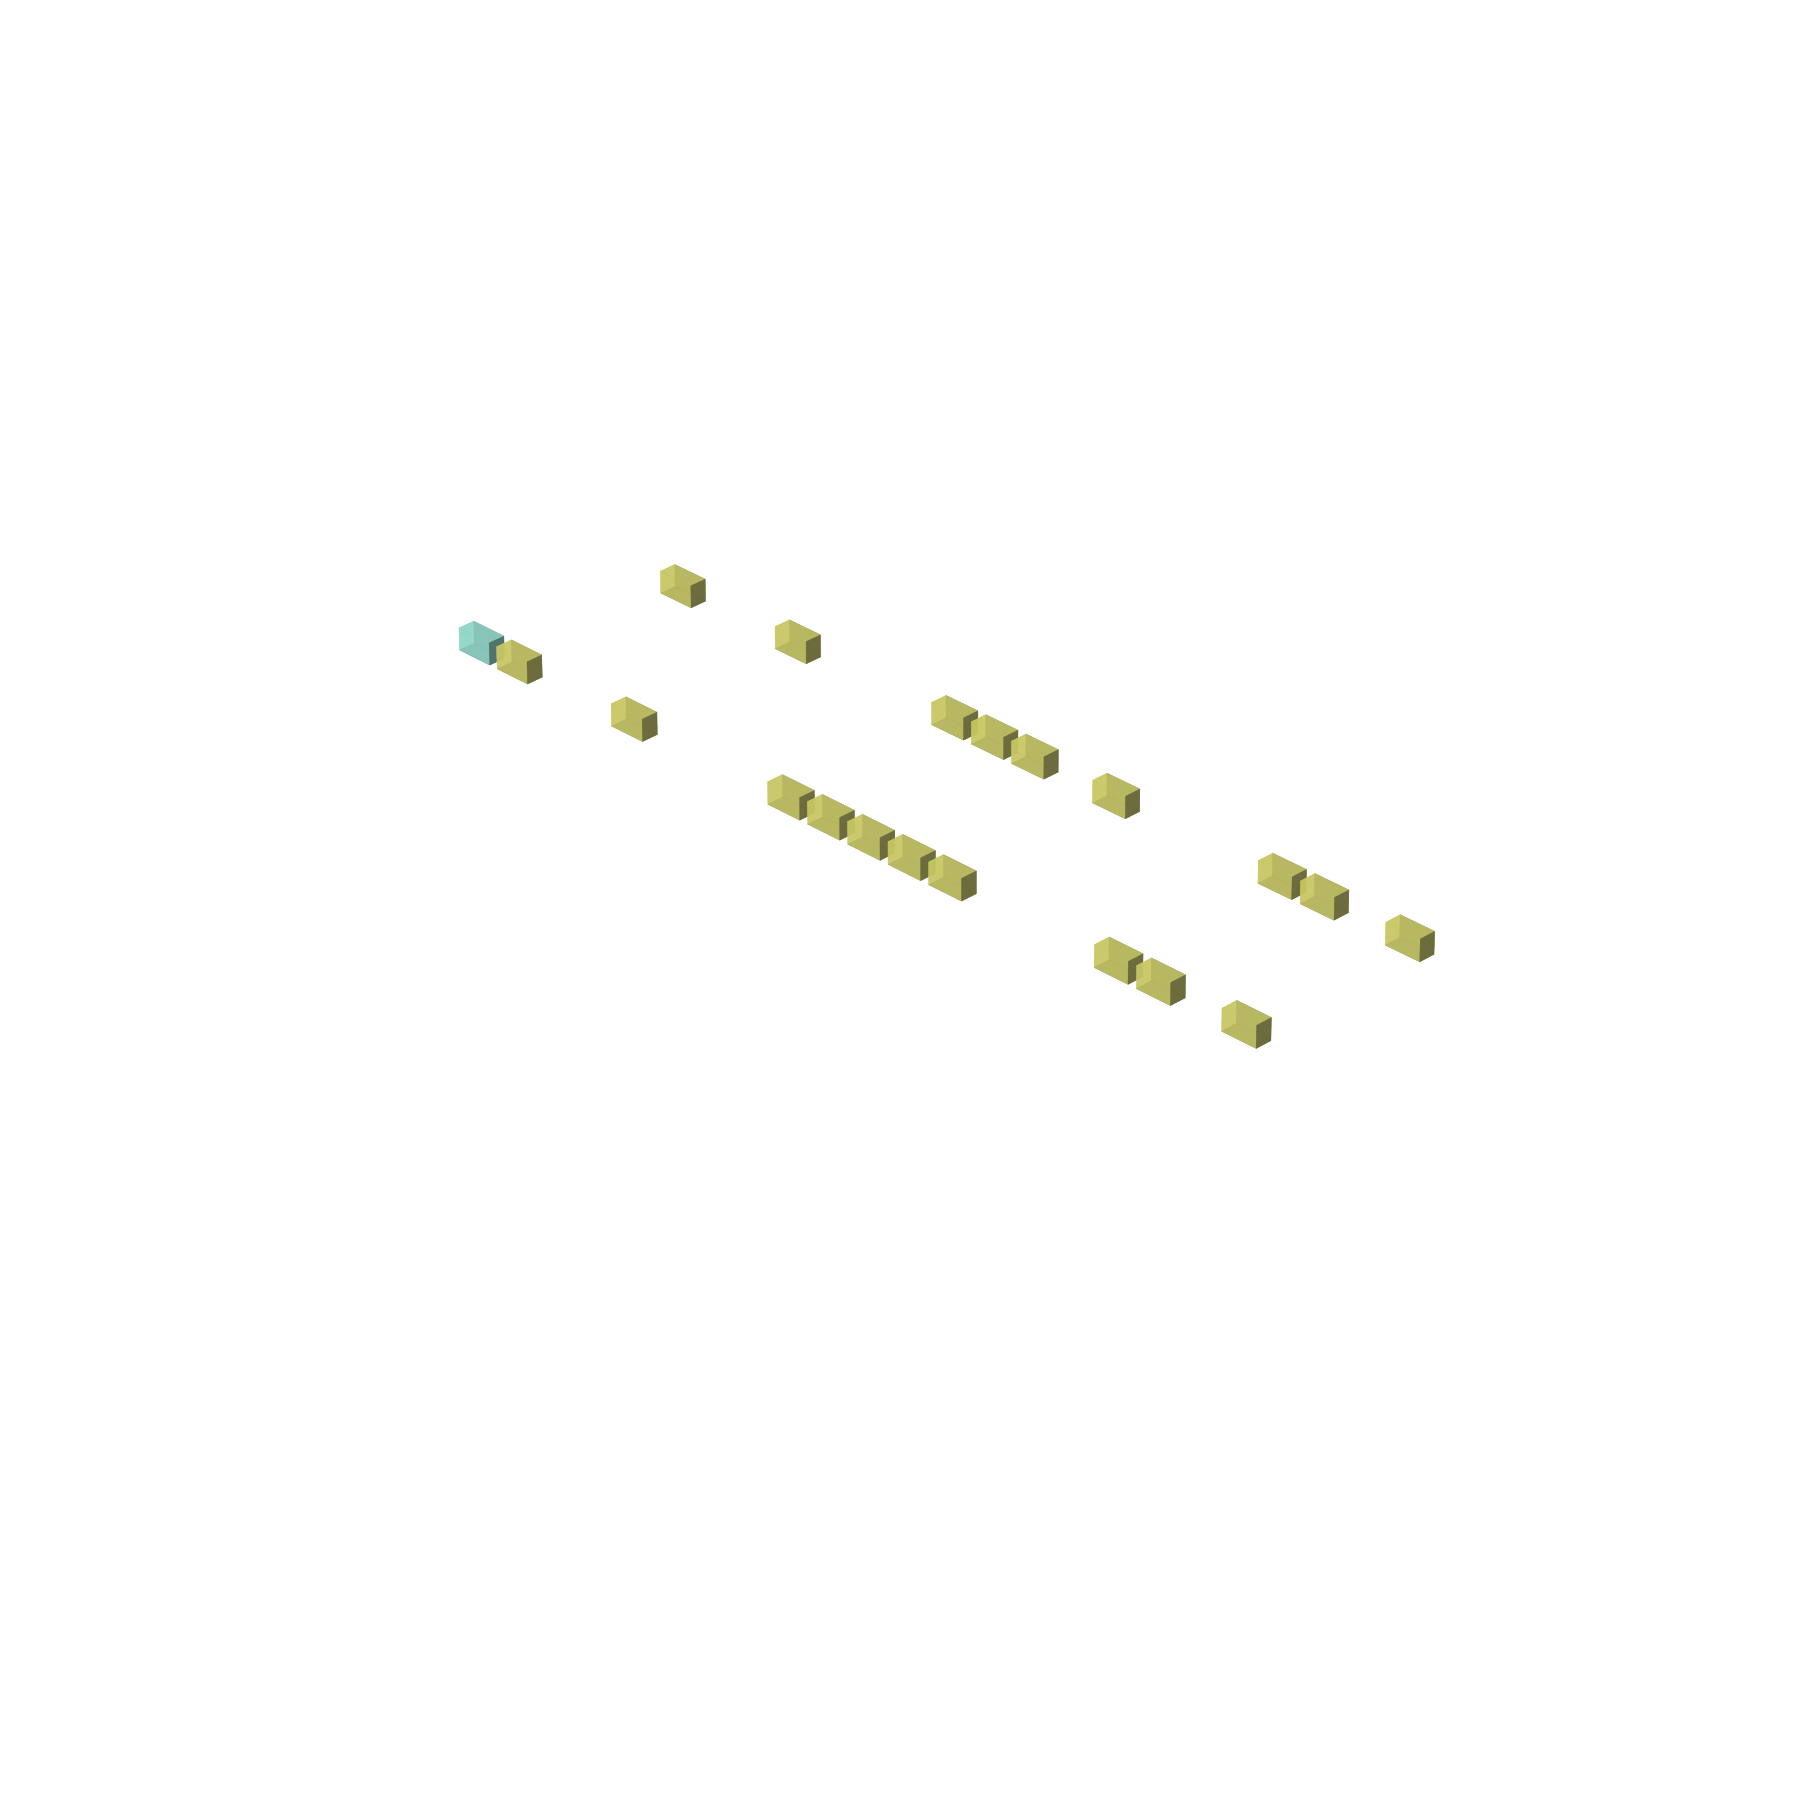

In [25]:
# Select our pattern
#screens = cullPattern(patterns[5])
import os, gc, sys

for i, pattern in enumerate([p for p in patterns if len(p) > 1]):
    screens = [p for p,s in pattern][:20]
    settings = [s for p,s in pattern]
    pattern_index = settings[0][-7]
    symmetry = settings[0][-1]
    for azim in [-45,-225]:
        if os.path.isfile(f'patterns/symmetries/pattern{pattern_index}_{symmetry}{azim}.png'):
            continue
        ((x,y,z), voxels, vcolors) = createVoxelData(screens)

        # and plot everything
        ax = plt.figure().add_subplot(projection='3d')
        ls = LightSource(45)
        ax.voxels(x,y,z,voxels, facecolors=vcolors, edgecolors=vcolors,lightsource=ls)
        ax.axis('off')
        ax.view_init(azim=azim, vertical_axis='y')
        img = fig2img(plt.gcf())
        """
        im1 = None
        if azim == -45:
            im1 = img.crop((img.width/4, img.height/4, 
                            (img.width/5) * 4, (img.height/4) * 3))
        else:
            OFFSET = 150
            im1 = img.crop(((img.width/4) - OFFSET, (img.height/4) - OFFSET,
                            ((img.width/5) * 4) - OFFSET, ((img.height/4) * 3) - OFFSET))
        """
        im1 = img
        newImage = []
        for item in im1.getdata():
            if item[:3] == (255, 255, 255):
                newImage.append((255, 255, 255, 0))
            else:
                newImage.append(item)

        im1.putdata(newImage)
        im1.save(f'patterns/symmetries/pattern{pattern_index}_{symmetry}{azim}.png')
        plt.clf()
        plt.close()
        del voxels, vcolors
        del im1,img, newImage, ax, ls
    gc.collect()


In [26]:
gc.collect()

25771

In [20]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]

# Get a sorted list of the objects and their sizes
mem = {
    key: value
    for key, value in sorted(
        [
            (x, sys.getsizeof(globals().get(x)))
            for x in dir()
        ],
        key=lambda x: x[1],
        reverse=True,
    )
}
mem

{'newImage': 235332032,
 'lines': 3617176,
 'vcolors': 1158600,
 'voxels': 144951,
 'ram_history': 54560,
 '_': 2272,
 '_19': 2272,
 'mem': 2272,
 '_i16': 2142,
 '_i17': 2141,
 '_iii': 2141,
 '_i11': 1719,
 '_i15': 1719,
 '_i13': 1444,
 '_i6': 1444,
 '_i9': 1444,
 '_i4': 1318,
 'LightSource': 1192,
 '_i1': 994,
 'patterns': 760,
 'settings': 760,
 'pattern': 672,
 'pattern_breaks': 672,
 'c64_to_rgb': 640,
 'colors_base': 640,
 '_i2': 625,
 '_i': 563,
 '_i19': 563,
 '_i18': 559,
 '_ii': 559,
 '_i20': 475,
 '_i3': 469,
 'raw_ram': 336,
 's': 336,
 'settings_ram': 336,
 'In': 264,
 '_ih': 264,
 '_i10': 248,
 '_i7': 248,
 'color_ram': 248,
 'h': 248,
 'Out': 232,
 '_oh': 232,
 'screens': 216,
 'input_file': 208,
 'colors': 184,
 '_i12': 144,
 '_i14': 144,
 '_i5': 144,
 '_i8': 144,
 'x': 144,
 'y': 144,
 'z': 144,
 'createVoxelData': 136,
 'cullPattern': 136,
 'explode': 136,
 'fig2img': 136,
 'firstNonZero': 136,
 'flatten': 136,
 'getLeftMostPixelForPattern': 136,
 'getRightMostPixelForP